In [1]:
import kalman
import observation_helpers

reload(observation_helpers)


def ConstructFilter(csvfile, obs_noise, system_noise, start_obs=2000, 
                  stop_obs=2500, dt=.25, dim_u=0):
    '''
    Construct the Kalman filter instance for a cluster of sensors. 
    
    Parameters
    ----------
    csvfile : integer
        integer index of sensor in pandas dataframe.  
    obs_noise : np.array(z_dim, z_dim) (default=None)
        Specify the observation noise covariance matrix.  Scalar if z_dim=1 (observation dimension)
    system_noise : np.array(mu_dim, mu_dim)
        Specifies the system (process) covariance matrix mu_dim is the state dimension
    start_obs : integer
        Starting observation for estimating the initial baseline value
    stop_obs : integer
        Stopping observation for estimating the initial baseline value
    dt : float
        Time interval between observations
    dim_u : dimension of control input. 
    
    
    Returns 
    ----------
    K : Kalman instance. 
    
    
#     mu_list : np.array(N_obs, dim_mu)
#         contains the updated state vector for each observation
    
#     sigma_list : contains the projected measurement covariance at each observation. 
    
    '''
    # Get number of sensors in cluster.
    nsensors = observation_helpers.GetNumSensors(csvfile)
    
    # Get total observation vector. 
    Y = np.array([observation_helpers.GetTimeSeries(csvfile, i_sensor)
                                     for i_sensor in range(1,nsensors+1)])
    
    # Let's estimate the initial baseline using the median data points, excluding NaNs
    baselines = np.array([np.median(Y[i_sensor,start_obs:stop_obs][~np.isnan(Y[i_sensor,start_obs:stop_obs])])
                                     for i_sensor in range(0,nsensors)])

    # Label and enumerate the state parameters. 
    state_params = ['D', 'Ddot', 'b', 'bdot'] # These are for each sensor 
    nparams = len(state_params) # Number of parameters/sensor
    state_labels = [] # This will hold the full set of state labels
    for i_sensor in range(nsensors): 
        for param in state_params: 
            state_labels.append(param + '_%i'%i_sensor)

    #---------------------------------------------------
    # Construct the transition matrix
    A = np.zeros((nsensors*nparams, nsensors*nparams))
    
    # First, just couple a sensor to itself
    for i_sensor in range(nsensors): 
        for i_param, param in enumerate(state_params):
            # Setup Newton's equations for each sensor with itself.
            if param == 'D': 
                A[i_sensor*nparams+i_param, i_sensor*nparams+i_param+0] = 1  # Position
                A[i_sensor*nparams+i_param, i_sensor*nparams+i_param+1] = dt # Velocity update
                A[i_sensor*nparams+i_param+1, i_sensor*nparams+i_param+1] = 1 # Velocity update
            if param == 'b': 
                A[i_sensor*nparams+i_param, i_sensor*nparams+i_param+0] = 1  # Position
                A[i_sensor*nparams+i_param, i_sensor*nparams+i_param+1] = dt # Velocity update
                A[i_sensor*nparams+i_param+1, i_sensor*nparams+i_param+1] = 1 # Velocity update

    # First observation that is not nan 
    Y0 = np.array([Y[i_sensor, np.argwhere(~np.isnan(Y[i_sensor]))[0]][0] for i_sensor in range(nsensors)])
    
    # Estimate initial state as first observation 
    mu_0 = [] 
    for i_sensor in range(nsensors):
        mu_0 += [-Y0[i_sensor]+baselines[i_sensor], 0., baselines[i_sensor], 0]
    mu_0 = np.array(mu_0)
    
    # Estimate for the initial state covariance.  Assume diagonal, and identical uncertainties. 
    sigma_0 = np.diag((50, 10, 10, 0)*nsensors)
    
    # Control Model 
    B = np.zeros((len(mu_0),dim_u))

    # Observation Matrix
    C = np.zeros((nsensors, len(mu_0)))
    for i_sensor in range(nsensors):
        C[i_sensor,:] = np.array([0, 0, 0, 0]*i_sensor + [-1, 0, +1, 0] + [0, 0, 0, 0]*(nsensors-i_sensor-1))
    
    # Observation control matrix
    D = None
    
    # Process noise.
    Q = system_noise
    
    # Observation Noise
    R = obs_noise 

    K = kalman.Kalman(mu_0, sigma_0, A, B, C, D, Q, R, state_labels)

    return K 
    


# Construct the joint Kalman filter (all nodes at once)

In [2]:
#============================================================
# Filter Parameters 
#============================================================
# Define the cluster filename
csvfile  = '../output/cluster_0_cleaned.pickle'
nsensors = observation_helpers.GetNumSensors(csvfile)
# Observations to use for estimating the baseline and sensor variance 
start_obs, stop_obs = 2000, 2500  
# Timestep 
dt=.25

# System noise needs to be estimated, but for now let's guess.
system_noise = np.diag([1e-3, 1e-3, 1e-3, 0]*nsensors)

# Estimate the observation noise of each sensor from the initial summertime (no-snow) variance 
obs_noise = np.array([observation_helpers.EstimateObservationNoise(csvfile, 
                                              sensor_number=i_sensor, 
                                              start_obs=start_obs, 
                                              stop_obs=stop_obs) for i_sensor in range(1,nsensors+1)])
#============================================================
# End Parameters 
#============================================================
reload(kalman)

# Load the observation vectors 
Y = np.array([observation_helpers.GetTimeSeries(csvfile, i_sensor)
                                     for i_sensor in range(1,nsensors+1)])
nobs = Y.shape[1] # number of observations
# Build the joint Kalman filter 
K = ConstructFilter(csvfile, np.diag(obs_noise), system_noise)

# print K.A.shape
# print K.sigma.shape

# Now iterate over the observations 

In [3]:
#%%timeit -n1 -r1 

mu_list = np.zeros((nobs, len(K.mu)))

for i_obs in range(nobs):
    K.predict()
    K.update(Y[:,i_obs])
    
    # Save the state at each step
    mu_list[i_obs] = K.mu
    
                
    if (i_obs%500)==0:
        print '\rForward pass on observation %i of %i'%(i_obs,Y.shape[1]), 
print 
#print 'Timing Information:'


Forward pass on observation 17500 of 17569


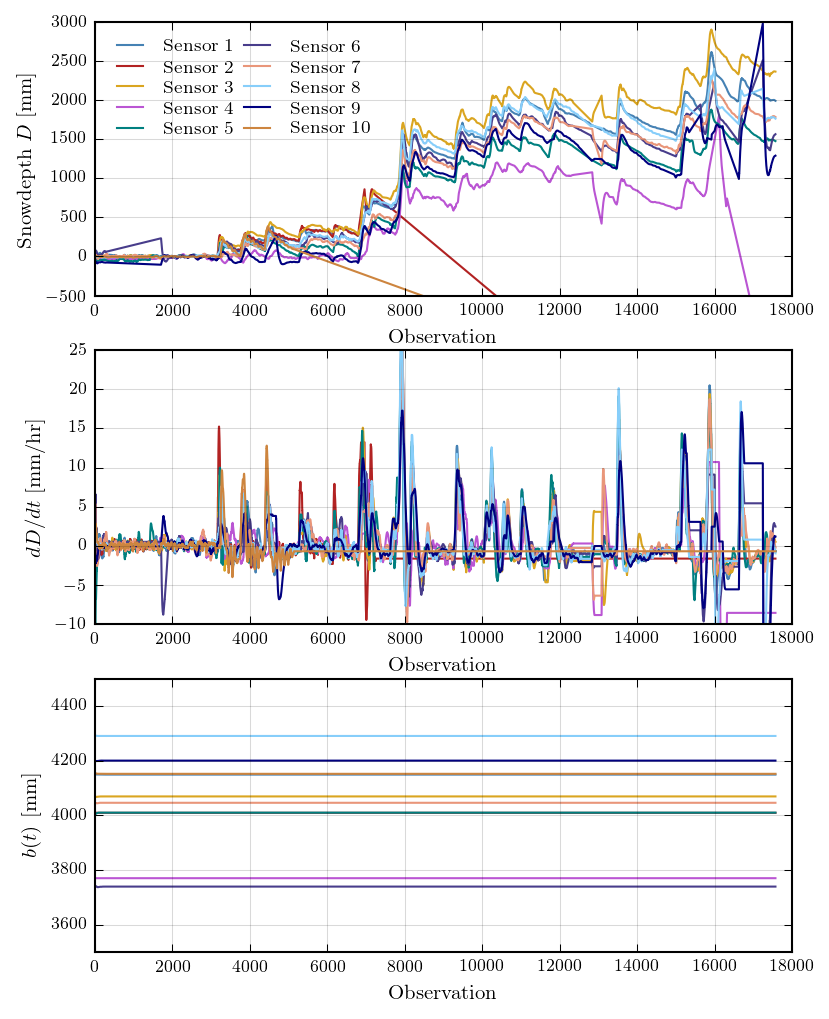

In [4]:

plt.figure(figsize=(6,8))

for i_sensor in range(nsensors):
    for i_param in range(3):
        plt.subplot(3,1,i_param+1)
        plt.plot(mu_list[:,i_sensor*4+i_param],label='Sensor %i'%(i_sensor+1))
        
        
plt.subplot(311)
# Plot the snowdepth 
plt.xlabel('Observation')
plt.ylabel('Snowdepth $D$ [mm]')
plt.grid(linestyle='-', alpha=.15)
plt.legend(loc=2, ncol=2, frameon=False, columnspacing=.2, labelspacing=.2)
plt.ylim(-500, 3000)

# -------------------------------
# Plot the velocity parameter
plt.subplot(312)
plt.xlabel('Observation')
plt.ylabel('$dD/dt$ [mm/hr]')
plt.ylim(-10,25)
plt.grid(linestyle='-', alpha=.15)

# -------------------------------
# Plot the baseline
plt.subplot(313)
plt.xlabel('Observation')
plt.ylabel('$b(t)$ [mm]')
plt.ylim(3.5e3,4.5e3)
plt.grid(linestyle='-', alpha=.15)

In [17]:
def ModifyTransitionMatrix(velocity_weights, K):
    '''
    Weight the velocity input from other sensors according to the given weights. 
    Taking a set of weights, on the next iteration v_i(t) = sum_j theta_ij*v_j(t-1) in
    This transformation is applied to the kalman transition matrix.
    
    Parameters
    ----------
    velocity_weights : np.array(n_nodes*n_nodes)
        flattened array of dimension (n_nodes, n_nodes) containing the velocity weight vector
    K : Kalman filter instance
        The Kalman filter instance that should be modified. 
    '''
    # Find the velocity indices in the state vector 
    vel_idx = K.state_labels.index('Ddot_0')
    
    n_nodes = int(np.sqrt(len(velocity_weights)))
    params_per_node = K.A.shape[0]/n_nodes
    try: 
        weights = np.reshape(velocity_weights, (n_nodes, n_nodes))
    except:
        raise Exception('Incorrect weight vector length.')
    
    # Find the indices of each other velocity vector
    idx = np.array([i_vel*params_per_node+vel_idx for i_vel in range(0, n_nodes)])
    
    for i_node in range(n_nodes):
        # Pick out the weights
        values = weights[i_node]
        # Find the row corresponding to the velocity state param of interest
        row = i_node*params_per_node+vel_idx
        K.A[row, idx] = weights[i_node]


def ModifyTransitionMatrixSingleRow(velocity_weights, K, i_node):
    '''
    Weight the velocity input for sensor i_sensor, from other sensors according to the given weights. 
    Taking a set of weights, on the next iteration v_i(t) = sum_j theta_ij*v_j(t-1) in
    This transformation is applied to the kalman transition matrix.
    
    Parameters
    ----------
    velocity_weights : np.array(n_nodes*n_nodes)
        flattened array of dimension (n_nodes, n_nodes) containing the velocity weight vector
    K : Kalman filter instance
        The Kalman filter instance that should be modified. 
    i_node : integer
        Sensor node index to assign weights to. 
    '''
    # Find the velocity indices in the state vector 
    vel_idx = K.state_labels.index('Ddot_0')
    
    n_nodes = len(velocity_weights)
    params_per_node = K.A.shape[0]/n_nodes
        
    # Find the indices of each other velocity vector
    idx = np.array([i_vel*params_per_node+vel_idx for i_vel in range(0, n_nodes)])

    # Find the row corresponding to the velocity state param of interest
    row = i_node*params_per_node+vel_idx
    K.A[row, idx] = velocity_weights

        
        
def OptimizeWeightsTarget(weights, obs, i_sensor):
    # Build the filter
    K = ConstructFilter(csvfile, np.diag(obs_noise), system_noise)
    #ModifyTransitionMatrix(weights, K)
    #print 'Current weight vector:'
    
    dim = int(np.sqrt(len(weights)))
#     print weights.reshape(dim, dim)
    
    ModifyTransitionMatrixSingleRow(weights, K, i_sensor)
    
    np.loglike = ()
    ll = 0 

    for i_obs in range(0, nobs):
    #for i_obs in range(5*nobs/10, 6*nobs/10):
        K.predict()
        ll += K.update(Y[:,i_obs])
    print '\r', weights, -ll, 
    return -ll

   
    
reload(kalman)

i_sensor = 1 

n_nodes = Y.shape[0]
#initial_weights = np.identity(n_nodes).flatten()
initial_weights = np.zeros(n_nodes)
initial_weights[i_sensor] = 1 

OptimizeWeightsTarget(initial_weights, Y, i_sensor=1)


[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.] 1171339.9973

1171339.9972959612

In [ ]:


def Optimize_Weights(i_sensor):
    
    #initial_weights = np.identity(n_nodes).flatten()
    initial_weights = np.zeros(n_nodes)
    initial_weights[i_sensor] = 1 

    from functools import partial
    f = partial(OptimizeWeightsTarget, obs=Y, i_sensor=i_sensor)

    from scipy.optimize import minimize
    bounds = [(-3,3) for i in range(len(initial_weights))]
    m = minimize(f, initial_weights, options={'eps':.01, 'disp' : True}, bounds=bounds)
    print 'Done with sensor %i'%i_sensor
    return m 

    
from multiprocessing import pool 
numpy.set_printoptions(linewidth=500, precision=4)
n_nodes = Y.shape[0]
#p = pool.Pool()
theta_i = map(Optimize_Weights, range(0,n_nodes))
    
    

[-3.   -3.   -3.   -3.   -3.    3.   -3.   -3.    3.   -2.99] nan Done with sensor 0
[-3.   -3.   -3.   -3.   -3.   -3.   -3.   -3.   -3.   -2.99] nan Done with sensor 1
[-3.   -3.   -3.    3.   -3.   -3.   -3.   -3.   -3.   -2.99] nan Done with sensor 2
[ -9.4494e-05  -9.4494e-05  -9.4494e-05   9.9987e-01  -9.4494e-05  -9.4494e-05  -9.4494e-05  -9.4494e-05  -9.4494e-05   9.9055e-03] 1175623.7092 Done with sensor 3
[-3.   -3.   -3.   -2.99 -3.   -3.   -3.   -3.   -3.   -3.  ] nan

In [20]:
numpy.set_printoptions(linewidth=500, precision=2)

weights = np.array([theta.x for theta in theta_i])
print weights

     

[[  1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [ -9.45e-05  -9.45e-05  -9.45e-05   1.00e+00  -9.45e-05  -9.45e-05  -9.45e-05  -9.45e-05  -9.45e-05  -9.45e-05]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   1.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   1.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   1.00